In [11]:
!pip install zemberek-python
!pip install trnlp
!pip install TurkishStemmer


In [12]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
from zemberek import TurkishTokenizer, TurkishMorphology, TurkishSentenceNormalizer
from TurkishStemmer import TurkishStemmer

# Initialize components
tokenizer = TurkishTokenizer.DEFAULT
turkish_stopwords = stopwords.words("turkish")
morphology = TurkishMorphology.create_with_defaults()
normalizer = TurkishSentenceNormalizer(morphology)
stemmer = TurkishStemmer()


2024-07-24 20:29:47,008 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 17.039382934570312



In [13]:
def tokenize(text):
    # Convert text to lowercase
    text = text.lower()
    # Tokenize text
    text = normalizer.normalize(text)
    tokens = tokenizer.tokenize(text)
    # Remove punctuation and special characters
    tokens = [stemmer.stem(token.content) for token in tokens if token.content.isalpha() and token.content not in turkish_stopwords]
    return tokens


In [14]:
import pandas as pd
df = pd.read_csv('/kaggle/input/drone-formation-data/output.csv')
df.dropna(inplace=True)

command = 'Çizgi formasyonunu yap'
label = 'Cizgi'
cleaned_command = 'cleaned command'
df[cleaned_command] = [tokenize(text) for text in df[command]]
df.head()

,Çizgi formasyonunu yap,Cizgi,cleaned command
0,V çiz,V,"[v, çiz]"
1,Ok başı yapıver,Ok başı,"[ok, baş, yapıversen]"
2,Üçgen olun,Üçgen,"[üçgen, ol]"
3,Çizgi çiz,Cizgi,"[çizg, çiz]"
4,V formasyonu oluştur,V,"[v, formasyon, oluş]"


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Çizgi formasyonunu yap  558 non-null    object
 1   Cizgi                   558 non-null    object
 2   cleaned command         558 non-null    object
dtypes: object(3)
memory usage: 13.2+ KB


In [16]:
cleaned_command = df[cleaned_command]
label = df[label]

In [18]:
from sklearn.model_selection import train_test_split
command_train, command_test, label_train, label_test = train_test_split(cleaned_command,label, test_size=0.2, random_state=42)

In [19]:
from torchtext.vocab import build_vocab_from_iterator

vocab = build_vocab_from_iterator(command_train, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

2024-07-24 20:34:37,204 - datasets - INFO
Msg: PyTorch version 2.1.2+cpu available.

2024-07-24 20:34:37,209 - datasets - INFO
Msg: Polars version 1.1.0 available.

2024-07-24 20:34:37,214 - datasets - INFO
Msg: TensorFlow version 2.15.0 available.

2024-07-24 20:34:37,220 - datasets - INFO
Msg: JAX version 0.4.30 available.

2024-07-24 20:34:37,224 - datasets - INFO
Msg: Apache Beam version 2.46.0 available.



In [20]:
import torch
from torch.nn.utils.rnn import pad_sequence
# Convert tokenized text to sequences and pad them
commands_train = [torch.tensor(vocab(cleaned_command), dtype=torch.long) for cleaned_command in command_train]
commands_test = [torch.tensor(vocab(cleaned_command), dtype=torch.long) for cleaned_command in command_test]

# Padding sequences
commands_seq_train = pad_sequence(commands_train, batch_first=True, padding_value=0)
commands_seq_test = pad_sequence(commands_test, batch_first=True, padding_value=0)

In [21]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoded_train = label_encoder.fit_transform(label_train)
label_encoded_test = label_encoder.transform(label_test)


In [22]:
from torch.utils.data import Dataset, DataLoader
class CommandDataset(Dataset):
    def __init__(self, commands, formations):
        self.commands = commands
        self.formations = torch.tensor(formations, dtype=torch.long)
    
    def __len__(self):
        return len(self.commands)
    
    def __getitem__(self, idx):
        return self.commands[idx], self.formations[idx]

train_dataset = CommandDataset(commands_seq_train, label_encoded_train)
test_dataset = CommandDataset(commands_seq_test, label_encoded_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

**Training loop**


In [23]:
import torch.nn as nn
import torch.optim as optim

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    
    def forward(self, x):
        x = self.embedding(x)
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

# Hyperparameters
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 256
output_dim = len(label_encoder.classes_)

# Instantiate the model, define the loss function and the optimizer
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [25]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for commands_batch, formations_batch in train_loader:
        commands_batch, formations_batch = commands_batch.to(device), formations_batch.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(commands_batch)
        
        # Calculate the loss
        loss = criterion(outputs, formations_batch)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')



Epoch 1/50, Loss: 1.6148018836975098
Epoch 2/50, Loss: 1.6571142673492432
Epoch 3/50, Loss: 1.6096488237380981
Epoch 4/50, Loss: 1.588793396949768
Epoch 5/50, Loss: 1.611985683441162
Epoch 6/50, Loss: 1.6052664518356323
Epoch 7/50, Loss: 1.5991382598876953
Epoch 8/50, Loss: 1.6041083335876465
Epoch 9/50, Loss: 1.54123055934906
Epoch 10/50, Loss: 1.6138454675674438
Epoch 11/50, Loss: 1.6308749914169312
Epoch 12/50, Loss: 1.6306897401809692
Epoch 13/50, Loss: 1.596139907836914
Epoch 14/50, Loss: 1.584741234779358
Epoch 15/50, Loss: 1.626120686531067
Epoch 16/50, Loss: 1.6355273723602295
Epoch 17/50, Loss: 1.6027064323425293
Epoch 18/50, Loss: 1.630907416343689
Epoch 19/50, Loss: 1.6139417886734009
Epoch 20/50, Loss: 1.5983151197433472
Epoch 21/50, Loss: 1.5211131572723389
Epoch 22/50, Loss: 1.4385703802108765
Epoch 23/50, Loss: 1.1037510633468628
Epoch 24/50, Loss: 0.7747405171394348
Epoch 25/50, Loss: 0.5753996968269348
Epoch 26/50, Loss: 0.49960675835609436
Epoch 27/50, Loss: 0.1865329

In [26]:
def preprocess_command(command):
    tokenized_command = tokenizer.tokenize(command)
    tokenized_command = [token.content for token in tokenized_command]
    command_seq = torch.tensor(vocab(tokenized_command), dtype=torch.long).unsqueeze(0)
    command_seq = pad_sequence(command_seq, batch_first=True, padding_value=0)
    return command_seq

def predict_top_n(command, n=3):
    command_seq = preprocess_command(command)
    command_seq = command_seq.to(device)
    with torch.no_grad():
        outputs = model(command_seq)
    probabilities = torch.softmax(outputs, dim=1)
    top_n_probabilities, top_n_indices = torch.topk(probabilities, n)
    
    top_n_formations = [label_encoder.inverse_transform([idx.item()])[0] for idx in top_n_indices[0]]
    top_n_probabilities = top_n_probabilities[0].tolist()
    
    return list(zip(top_n_formations, top_n_probabilities))

# Use the model to make predictions
command = "ücgen gibi bir şey yap"
top_guesses = predict_top_n(command, n=5)
print(top_guesses)

[('Cizgi', 0.9872792959213257), ('Üçgen', 0.010139628313481808), ('V', 0.000948993198107928), ('voleybol', 0.000826567760668695), ('Ok başı', 0.0008056325023062527)]


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix')
    plt.show()


**Evulation Loop**

In [29]:

model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for commands_batch, formations_batch in test_loader:
        commands_batch, formations_batch = commands_batch.to(device), formations_batch.to(device)
        outputs = model(commands_batch)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(formations_batch.cpu().numpy())

# Identify incorrect predictions
incorrect_predictions = []
for i, (prediction, label) in enumerate(zip(all_predictions, all_labels)):
    if prediction != label:
        incorrect_predictions.append((i, prediction, label))

# Print incorrect predictions
print("Incorrect Predictions:")
for idx, prediction, label in incorrect_predictions:
    command_text = ' '.join(str(token.item()) for token in commands_test[idx])
    actual_label = label_encoder.inverse_transform([label])[0]
    predicted_label = label_encoder.inverse_transform([prediction])[0]
    print(f"Index: {idx}, Command: {command_text}, Actual: {actual_label}, Predicted: {predicted_label}")


Incorrect Predictions:
Index: 9, Command: 202 127 10 42 0 28, Actual: voleybol, Predicted: Üçgen
Index: 23, Command: 0 0 0 8, Actual: Ok başı, Predicted: Cizgi
Index: 25, Command: 70 0 8, Actual: Üçgen, Predicted: Cizgi
Index: 29, Command: 0 0, Actual: voleybol, Predicted: Cizgi
Index: 89, Command: 0 0 182 0 0 138 102 96 0 31, Actual: V, Predicted: Cizgi
Index: 92, Command: 0 0, Actual: voleybol, Predicted: Cizgi


Accuracy: 0.9464
Precision: 0.9550
Recall: 0.9464
F1 Score: 0.9477


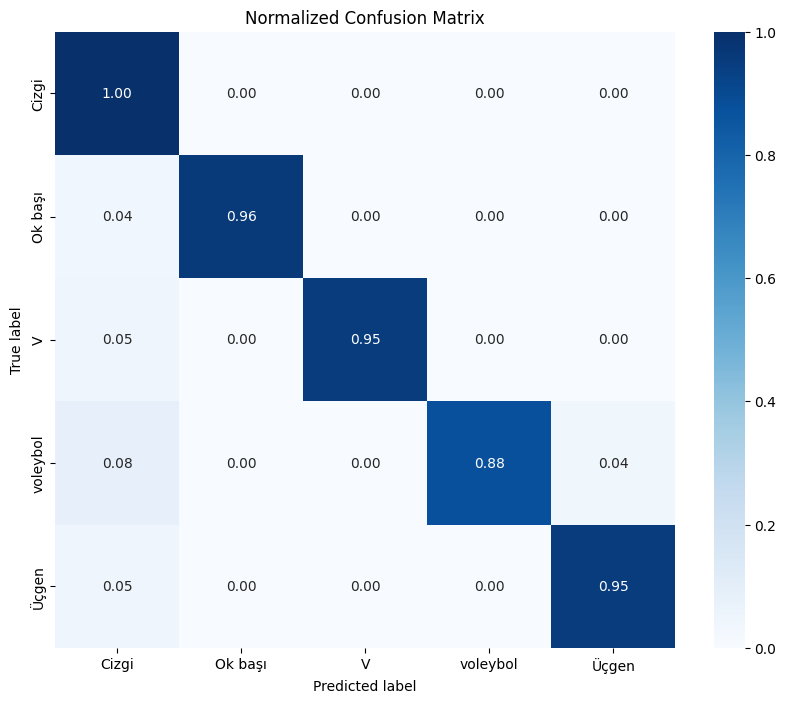

In [30]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
def evaluate_model(model, dataloader):
    model = model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for commands_batch, formations_batch in dataloader:
            commands_batch = commands_batch.to(device)
            formations_batch = formations_batch.to(device)
            outputs = model(commands_batch)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(formations_batch.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    return accuracy, precision, recall, f1, all_labels, all_preds

# Evaluate the model on the test set and get predictions
accuracy, precision, recall, f1, y_true, y_pred = evaluate_model(model, test_loader)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=label_encoder.classes_)
